# Approach: Embedding + MLP

In [5]:
import optuna
from optuna.trial import Trial
import numpy as np


In [6]:
import os
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import csv


In [7]:
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")

# IN KAGGLE:
#train = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
#test = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv")

### Generate Embeddings

In [8]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# IN KAGGLE (UPLOAD sbert_model.zip TO NOTEBOOK AS DATASET FIRST):
#sbert_model = SentenceTransformer("/kaggle/input/sentence-bert")

embeddings = sbert_model.encode(train["full_text"].tolist(), show_progress_bar=True)

train["embedding"] = embeddings.tolist()


Batches: 100%|██████████| 123/123 [00:10<00:00, 11.46it/s]


### Define Dataset & Dataloader

In [9]:

class SBERTEmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe["embedding"].tolist()
        self.labels = dataframe[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]].values.astype(float)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        return embedding, labels


In [10]:
dataset = SBERTEmbeddingDataset(train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### Define simple Feed Forward Net

In [11]:
import torch.nn as nn

def make_model(
    hidden1: int = 512,
    hidden2: int = 256,
    hidden3: int = 128,
    dropout1: float = 0.4,
    dropout2: float = 0.3,
    dropout3: float = 0.2,
    in_dim: int = 384,        # SBERT-Embedding-Dim
    out_dim: int = 6          # Multi-Target Regression
):
    return nn.Sequential(
        nn.Linear(in_dim, hidden1),
        nn.ReLU(), nn.BatchNorm1d(hidden1), nn.Dropout(dropout1),

        nn.Linear(hidden1, hidden2),
        nn.ReLU(), nn.BatchNorm1d(hidden2), nn.Dropout(dropout2),

        nn.Linear(hidden2, hidden3),
        nn.ReLU(), nn.BatchNorm1d(hidden3), nn.Dropout(dropout3),

        nn.Linear(hidden3, out_dim)
    )


### Train Net

In [12]:
class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, preds, targets):
        # preds/targets: [batch_size, num_targets]
        colwise_mse = self.mse(preds, targets).mean(dim=0)  # Mittelwert pro Spalte
        colwise_rmse = torch.sqrt(colwise_mse + 1e-8)       # RMSE pro Ziel
        return colwise_rmse.mean()                          # Mittelwert über Ziele


In [14]:
def objective(trial: Trial) -> float:
    # -------- Hyperparameter-Suchraum --------
    hidden1  = trial.suggest_int ("hidden1", 256, 768, step=64)
    hidden2  = trial.suggest_int ("hidden2", 128, hidden1, step=64)
    hidden3  = trial.suggest_int ("hidden3",  64, hidden2, step=64)

    drop1    = trial.suggest_float("drop1", 0.0, 0.5)
    drop2    = trial.suggest_float("drop2", 0.0, 0.5)
    drop3    = trial.suggest_float("drop3", 0.0, 0.5)

    lr       = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    wd       = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    bs       = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs   = trial.suggest_int("num_epochs", 8, 30)

    # -------- Modell-Fabrik für diesen Trial --------
    model_fn = lambda: make_model(
        hidden1, hidden2, hidden3,
        drop1, drop2, drop3
    )

    # -------- Cross-Validation ausführen --------
    fold_losses, _, _ = cross_validate_kfold(
        dataset,                # schon früher erstellt
        model_fn,
        k           = 5,
        num_epochs  = epochs,
        lr          = lr,
        batch_size  = bs,
        weight_decay= wd,
    )

    mean_val_loss = float(np.mean(fold_losses))
    return mean_val_loss    # minimieren


In [15]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def cross_validate_kfold(
        dataset,
        model_fn,
        k: int = 5,
        num_epochs: int = 10,
        lr: float = 1e-3,
        batch_size: int = 32,
        weight_decay: float = 1e-2,
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    fold_final_val_losses = []      # letzter Val-Loss je Fold (für Statistik)
    fold_histories = []             # gesamte Loss-Historie je Fold

    plt.figure(figsize=(8, 5))

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset), start=1):
        print(f"\n─── Fold {fold} ───")

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset   = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset,   batch_size=batch_size)

        model = model_fn().to(device)

        # ✔ AdamW statt Adam
        optimizer = torch.optim.AdamW(model.parameters(),
                                      lr=lr,
                                      weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               mode='min',
                                                               factor=0.5,
                                                               patience=2)

        loss_fn = torch.nn.MSELoss()          # oder dein eigenes Loss
        val_loss_history = []                 # log für diesen Fold

        for epoch in range(1, num_epochs + 1):
            # ----- Training -----
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)

                loss = loss_fn(preds, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # ----- Validation -----
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    preds = model(xb)
                    val_loss += loss_fn(preds, yb).item() * xb.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            scheduler.step(avg_val_loss)
            val_loss_history.append(avg_val_loss)

            print(f"Fold {fold} | Epoch {epoch:>2}/{num_epochs} | "
                  f"val loss: {avg_val_loss:.4f}")

        # ----- Logging für Plot -----
        fold_histories.append(val_loss_history)
        fold_final_val_losses.append(val_loss_history[-1])

        plt.plot(range(1, num_epochs + 1),
                 val_loss_history,
                 label=f"Fold {fold}")

    # ----- Gesamter Plot -----
    plt.title("Validation-Loss je Fold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

    mean_final = sum(fold_final_val_losses) / k
    print(f"\n⟹ Ø Validation-Loss über {k} Folds: {mean_final:.4f}")

    # gib ggf. zusätzlich die komplette Historie zurück
    return fold_final_val_losses, fold_histories, model


[I 2025-05-28 01:09:12,884] A new study created in memory with name: no-name-e2f5e8cf-624e-4748-8f3f-c7e00e0aa9ea



─── Fold 1 ───
Fold 1 | Epoch  1/30 | val loss: 10.3955
Fold 1 | Epoch  2/30 | val loss: 10.1808
Fold 1 | Epoch  3/30 | val loss: 10.1767
Fold 1 | Epoch  4/30 | val loss: 10.1902
Fold 1 | Epoch  5/30 | val loss: 10.0512
Fold 1 | Epoch  6/30 | val loss: 9.9137
Fold 1 | Epoch  7/30 | val loss: 10.0214
Fold 1 | Epoch  8/30 | val loss: 9.9062
Fold 1 | Epoch  9/30 | val loss: 9.8510
Fold 1 | Epoch 10/30 | val loss: 9.6268
Fold 1 | Epoch 11/30 | val loss: 9.6437
Fold 1 | Epoch 12/30 | val loss: 9.5690
Fold 1 | Epoch 13/30 | val loss: 9.7253
Fold 1 | Epoch 14/30 | val loss: 9.5202
Fold 1 | Epoch 15/30 | val loss: 9.4624
Fold 1 | Epoch 16/30 | val loss: 9.3406
Fold 1 | Epoch 17/30 | val loss: 9.3905
Fold 1 | Epoch 18/30 | val loss: 9.2014
Fold 1 | Epoch 19/30 | val loss: 9.1562
Fold 1 | Epoch 20/30 | val loss: 9.2177
Fold 1 | Epoch 21/30 | val loss: 8.8426
Fold 1 | Epoch 22/30 | val loss: 8.7410
Fold 1 | Epoch 23/30 | val loss: 8.7212
Fold 1 | Epoch 24/30 | val loss: 8.5733
Fold 1 | Epoch 25/

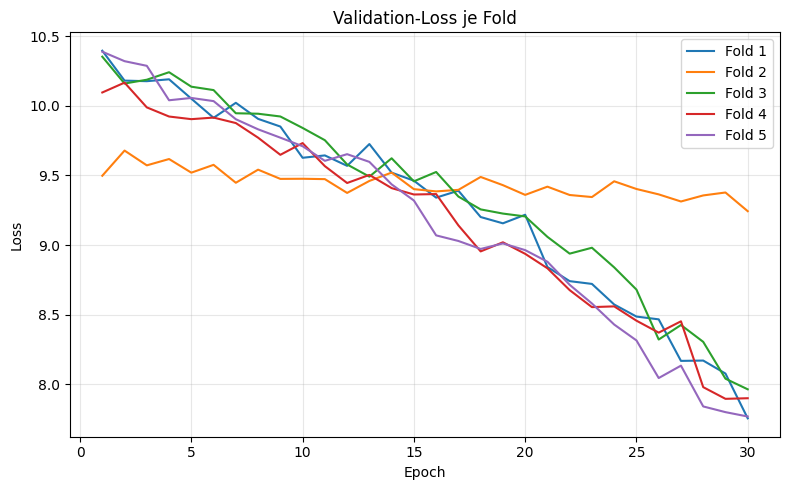

[I 2025-05-28 01:10:12,617] Trial 0 finished with value: 8.126663766077352 and parameters: {'hidden1': 448, 'hidden2': 448, 'hidden3': 384, 'drop1': 0.2993292420985183, 'drop2': 0.07800932022121826, 'drop3': 0.07799726016810132, 'lr': 1.3066739238053272e-05, 'weight_decay': 0.0029154431891537554, 'batch_size': 32, 'num_epochs': 30}. Best is trial 0 with value: 8.126663766077352.



⟹ Ø Validation-Loss über 5 Folds: 8.1267

─── Fold 1 ───
Fold 1 | Epoch  1/16 | val loss: 10.0989
Fold 1 | Epoch  2/16 | val loss: 9.5991
Fold 1 | Epoch  3/16 | val loss: 9.2307
Fold 1 | Epoch  4/16 | val loss: 9.0088
Fold 1 | Epoch  5/16 | val loss: 8.5457
Fold 1 | Epoch  6/16 | val loss: 8.1579
Fold 1 | Epoch  7/16 | val loss: 7.6893
Fold 1 | Epoch  8/16 | val loss: 6.5537
Fold 1 | Epoch  9/16 | val loss: 6.0302
Fold 1 | Epoch 10/16 | val loss: 5.1691
Fold 1 | Epoch 11/16 | val loss: 4.1013
Fold 1 | Epoch 12/16 | val loss: 3.6143
Fold 1 | Epoch 13/16 | val loss: 2.7266
Fold 1 | Epoch 14/16 | val loss: 2.2202
Fold 1 | Epoch 15/16 | val loss: 1.6181
Fold 1 | Epoch 16/16 | val loss: 1.1697

─── Fold 2 ───
Fold 2 | Epoch  1/16 | val loss: 10.2151
Fold 2 | Epoch  2/16 | val loss: 10.0110
Fold 2 | Epoch  3/16 | val loss: 9.6981
Fold 2 | Epoch  4/16 | val loss: 9.3557
Fold 2 | Epoch  5/16 | val loss: 8.8733
Fold 2 | Epoch  6/16 | val loss: 8.3429
Fold 2 | Epoch  7/16 | val loss: 7.7396
Fol

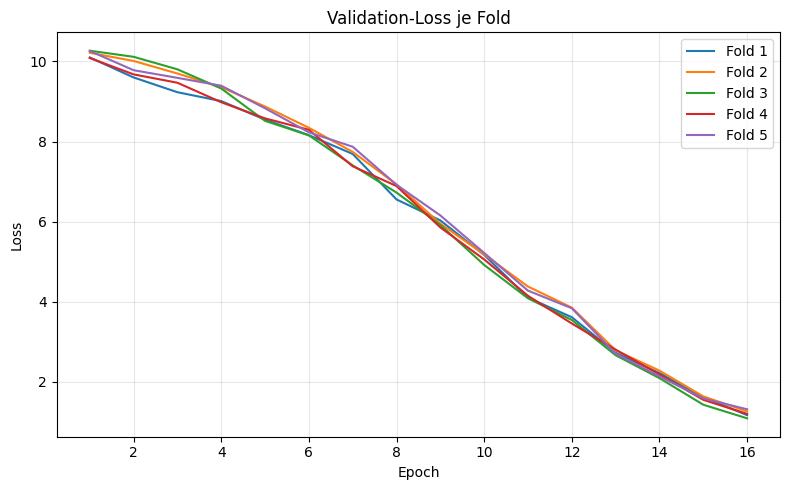

[I 2025-05-28 01:11:04,893] Trial 1 finished with value: 1.2080925073534428 and parameters: {'hidden1': 704, 'hidden2': 256, 'hidden3': 64, 'drop1': 0.09170225492671691, 'drop2': 0.15212112147976886, 'drop3': 0.2623782158161189, 'lr': 7.309539835912905e-05, 'weight_decay': 1.461896279370496e-05, 'batch_size': 16, 'num_epochs': 16}. Best is trial 1 with value: 1.2080925073534428.



⟹ Ø Validation-Loss über 5 Folds: 1.2081

─── Fold 1 ───
Fold 1 | Epoch  1/26 | val loss: 9.4883
Fold 1 | Epoch  2/26 | val loss: 9.4101
Fold 1 | Epoch  3/26 | val loss: 9.0756
Fold 1 | Epoch  4/26 | val loss: 8.4889
Fold 1 | Epoch  5/26 | val loss: 8.1192
Fold 1 | Epoch  6/26 | val loss: 7.3332
Fold 1 | Epoch  7/26 | val loss: 6.7150
Fold 1 | Epoch  8/26 | val loss: 5.7388
Fold 1 | Epoch  9/26 | val loss: 4.7080
Fold 1 | Epoch 10/26 | val loss: 3.8416
Fold 1 | Epoch 11/26 | val loss: 3.1088
Fold 1 | Epoch 12/26 | val loss: 2.3640
Fold 1 | Epoch 13/26 | val loss: 1.6538
Fold 1 | Epoch 14/26 | val loss: 1.1605
Fold 1 | Epoch 15/26 | val loss: 0.8802
Fold 1 | Epoch 16/26 | val loss: 0.6474
Fold 1 | Epoch 17/26 | val loss: 0.5059
Fold 1 | Epoch 18/26 | val loss: 0.4678
Fold 1 | Epoch 19/26 | val loss: 0.3835
Fold 1 | Epoch 20/26 | val loss: 0.3802
Fold 1 | Epoch 21/26 | val loss: 0.3867
Fold 1 | Epoch 22/26 | val loss: 0.3682
Fold 1 | Epoch 23/26 | val loss: 0.3692
Fold 1 | Epoch 24/26 |

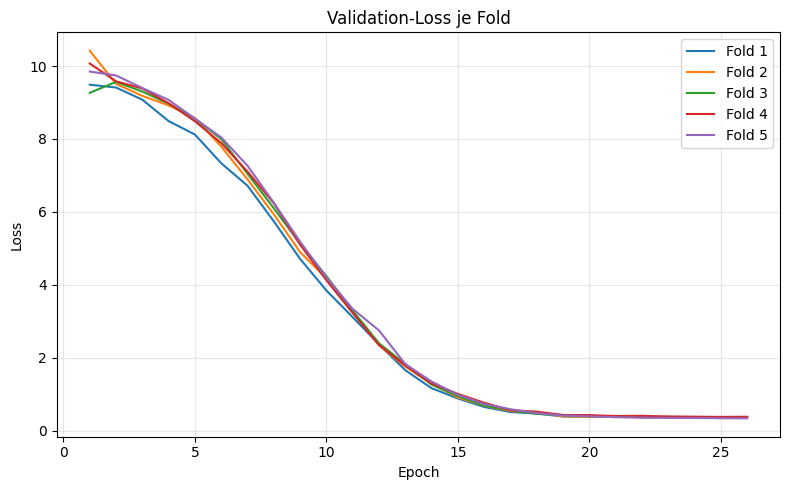

[I 2025-05-28 01:11:41,626] Trial 2 finished with value: 0.35795241597956234 and parameters: {'hidden1': 512, 'hidden2': 448, 'hidden3': 128, 'drop1': 0.2571172192068058, 'drop2': 0.29620728443102123, 'drop3': 0.023225206359998862, 'lr': 0.000164092867306479, 'weight_decay': 4.809461967501575e-06, 'batch_size': 64, 'num_epochs': 26}. Best is trial 2 with value: 0.35795241597956234.



⟹ Ø Validation-Loss über 5 Folds: 0.3580

─── Fold 1 ───
Fold 1 | Epoch  1/19 | val loss: 9.8431
Fold 1 | Epoch  2/19 | val loss: 9.8364
Fold 1 | Epoch  3/19 | val loss: 9.7152
Fold 1 | Epoch  4/19 | val loss: 9.7743
Fold 1 | Epoch  5/19 | val loss: 9.7078
Fold 1 | Epoch  6/19 | val loss: 9.6720
Fold 1 | Epoch  7/19 | val loss: 9.7790
Fold 1 | Epoch  8/19 | val loss: 9.6564
Fold 1 | Epoch  9/19 | val loss: 9.6205
Fold 1 | Epoch 10/19 | val loss: 9.6019
Fold 1 | Epoch 11/19 | val loss: 9.5882
Fold 1 | Epoch 12/19 | val loss: 9.4965
Fold 1 | Epoch 13/19 | val loss: 9.5438
Fold 1 | Epoch 14/19 | val loss: 9.4158
Fold 1 | Epoch 15/19 | val loss: 9.4120
Fold 1 | Epoch 16/19 | val loss: 9.4422
Fold 1 | Epoch 17/19 | val loss: 9.3721
Fold 1 | Epoch 18/19 | val loss: 9.3813
Fold 1 | Epoch 19/19 | val loss: 9.3185

─── Fold 2 ───
Fold 2 | Epoch  1/19 | val loss: 9.9698
Fold 2 | Epoch  2/19 | val loss: 10.0095
Fold 2 | Epoch  3/19 | val loss: 9.9987
Fold 2 | Epoch  4/19 | val loss: 9.9610
Fold 

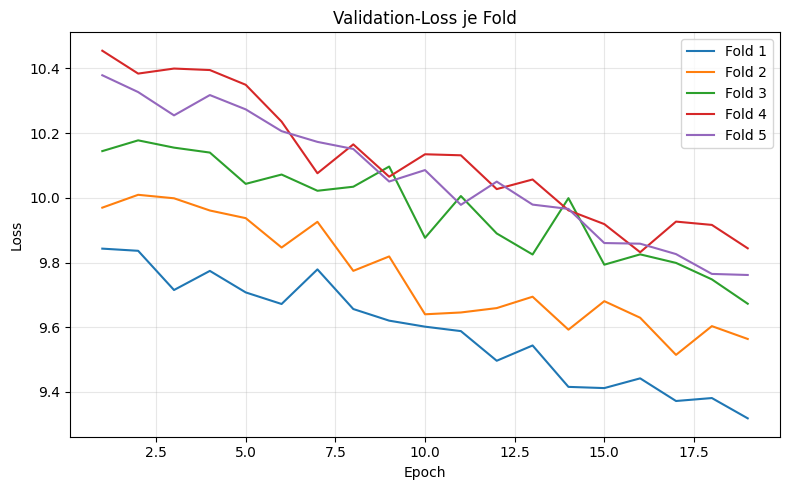

[I 2025-05-28 01:12:18,341] Trial 3 finished with value: 9.632190805994583 and parameters: {'hidden1': 384, 'hidden2': 128, 'hidden3': 128, 'drop1': 0.22007624686980065, 'drop2': 0.06101911742238941, 'drop3': 0.2475884550556351, 'lr': 1.1715937392307055e-05, 'weight_decay': 0.004337920697490943, 'batch_size': 32, 'num_epochs': 19}. Best is trial 2 with value: 0.35795241597956234.



⟹ Ø Validation-Loss über 5 Folds: 9.6322

─── Fold 1 ───
Fold 1 | Epoch  1/15 | val loss: 9.6077
Fold 1 | Epoch  2/15 | val loss: 9.2718
Fold 1 | Epoch  3/15 | val loss: 8.7889
Fold 1 | Epoch  4/15 | val loss: 8.1914
Fold 1 | Epoch  5/15 | val loss: 7.1040
Fold 1 | Epoch  6/15 | val loss: 5.9518
Fold 1 | Epoch  7/15 | val loss: 4.6717
Fold 1 | Epoch  8/15 | val loss: 3.3236
Fold 1 | Epoch  9/15 | val loss: 2.3709
Fold 1 | Epoch 10/15 | val loss: 1.5129
Fold 1 | Epoch 11/15 | val loss: 1.0217
Fold 1 | Epoch 12/15 | val loss: 0.7851
Fold 1 | Epoch 13/15 | val loss: 0.5997
Fold 1 | Epoch 14/15 | val loss: 0.5496
Fold 1 | Epoch 15/15 | val loss: 0.4500

─── Fold 2 ───
Fold 2 | Epoch  1/15 | val loss: 9.5442
Fold 2 | Epoch  2/15 | val loss: 9.2539
Fold 2 | Epoch  3/15 | val loss: 8.7508
Fold 2 | Epoch  4/15 | val loss: 8.0689
Fold 2 | Epoch  5/15 | val loss: 7.2151
Fold 2 | Epoch  6/15 | val loss: 5.9635
Fold 2 | Epoch  7/15 | val loss: 4.8158
Fold 2 | Epoch  8/15 | val loss: 3.4152
Fold 2

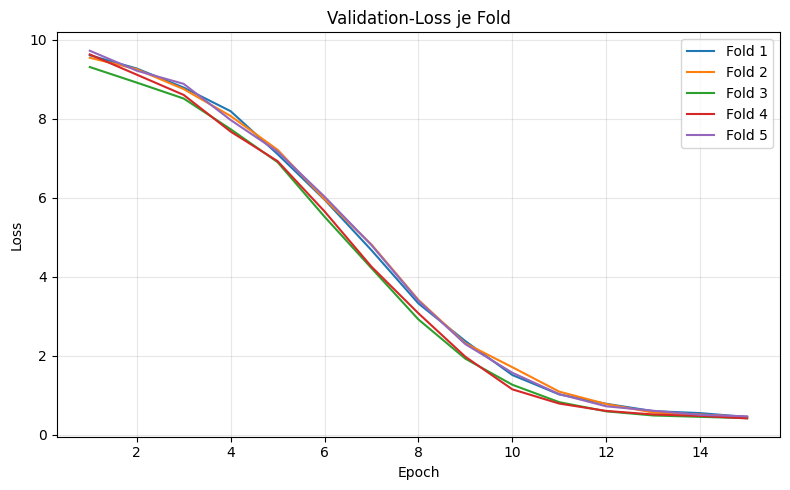

[I 2025-05-28 01:12:46,158] Trial 4 finished with value: 0.4412010793625708 and parameters: {'hidden1': 512, 'hidden2': 192, 'hidden3': 192, 'drop1': 0.3875664116805573, 'drop2': 0.46974947078209456, 'drop3': 0.4474136752138244, 'lr': 0.0001569639638866114, 'weight_decay': 0.0048696409415209, 'batch_size': 32, 'num_epochs': 15}. Best is trial 2 with value: 0.35795241597956234.



⟹ Ø Validation-Loss über 5 Folds: 0.4412

─── Fold 1 ───
Fold 1 | Epoch  1/12 | val loss: 10.1794
Fold 1 | Epoch  2/12 | val loss: 10.1790
Fold 1 | Epoch  3/12 | val loss: 10.0372
Fold 1 | Epoch  4/12 | val loss: 9.9781
Fold 1 | Epoch  5/12 | val loss: 9.8734
Fold 1 | Epoch  6/12 | val loss: 9.8471
Fold 1 | Epoch  7/12 | val loss: 9.7722
Fold 1 | Epoch  8/12 | val loss: 9.7447
Fold 1 | Epoch  9/12 | val loss: 9.7178
Fold 1 | Epoch 10/12 | val loss: 9.6357
Fold 1 | Epoch 11/12 | val loss: 9.5370
Fold 1 | Epoch 12/12 | val loss: 9.5442

─── Fold 2 ───
Fold 2 | Epoch  1/12 | val loss: 10.4110
Fold 2 | Epoch  2/12 | val loss: 10.3001
Fold 2 | Epoch  3/12 | val loss: 10.3123
Fold 2 | Epoch  4/12 | val loss: 10.1274
Fold 2 | Epoch  5/12 | val loss: 10.1877
Fold 2 | Epoch  6/12 | val loss: 10.0896
Fold 2 | Epoch  7/12 | val loss: 10.0495
Fold 2 | Epoch  8/12 | val loss: 10.0028
Fold 2 | Epoch  9/12 | val loss: 9.9878
Fold 2 | Epoch 10/12 | val loss: 9.8753
Fold 2 | Epoch 11/12 | val loss: 9.

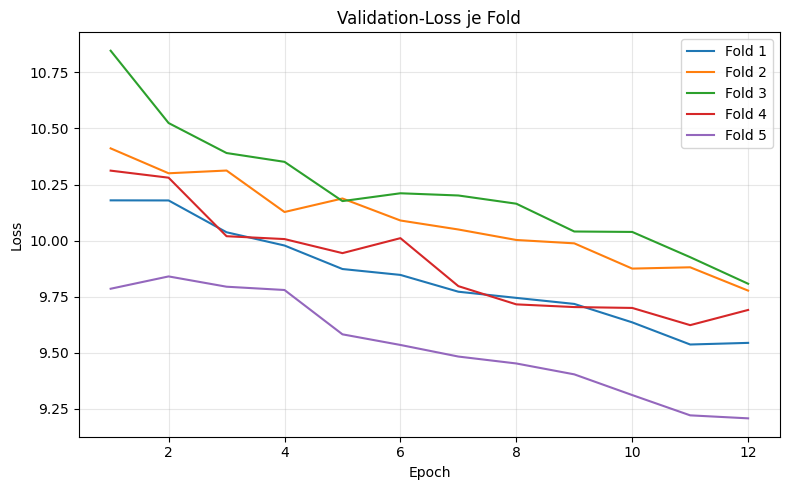

[I 2025-05-28 01:13:09,211] Trial 5 finished with value: 9.605597196730502 and parameters: {'hidden1': 448, 'hidden2': 192, 'hidden3': 192, 'drop1': 0.17837666334679464, 'drop2': 0.14046725484369038, 'drop3': 0.27134804157912423, 'lr': 1.913588048769229e-05, 'weight_decay': 0.0016172900811143157, 'batch_size': 32, 'num_epochs': 12}. Best is trial 2 with value: 0.35795241597956234.



⟹ Ø Validation-Loss über 5 Folds: 9.6056

─── Fold 1 ───
Fold 1 | Epoch  1/9 | val loss: 9.6604
Fold 1 | Epoch  2/9 | val loss: 9.2546
Fold 1 | Epoch  3/9 | val loss: 9.0722
Fold 1 | Epoch  4/9 | val loss: 8.2310
Fold 1 | Epoch  5/9 | val loss: 7.2389
Fold 1 | Epoch  6/9 | val loss: 6.4272
Fold 1 | Epoch  7/9 | val loss: 5.3296
Fold 1 | Epoch  8/9 | val loss: 4.1744
Fold 1 | Epoch  9/9 | val loss: 3.0063

─── Fold 2 ───
Fold 2 | Epoch  1/9 | val loss: 9.5172
Fold 2 | Epoch  2/9 | val loss: 9.2363
Fold 2 | Epoch  3/9 | val loss: 8.9147
Fold 2 | Epoch  4/9 | val loss: 8.2146
Fold 2 | Epoch  5/9 | val loss: 7.4670
Fold 2 | Epoch  6/9 | val loss: 6.4873
Fold 2 | Epoch  7/9 | val loss: 5.3886
Fold 2 | Epoch  8/9 | val loss: 4.0451
Fold 2 | Epoch  9/9 | val loss: 3.0050

─── Fold 3 ───
Fold 3 | Epoch  1/9 | val loss: 9.8546
Fold 3 | Epoch  2/9 | val loss: 9.6400
Fold 3 | Epoch  3/9 | val loss: 8.8937
Fold 3 | Epoch  4/9 | val loss: 8.6968
Fold 3 | Epoch  5/9 | val loss: 7.9890
Fold 3 | Epoc

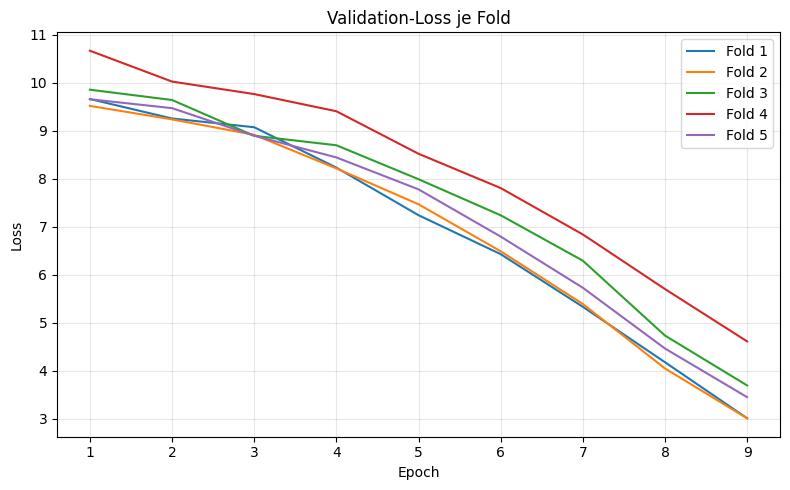

[I 2025-05-28 01:13:41,805] Trial 6 finished with value: 3.551364581635931 and parameters: {'hidden1': 256, 'hidden2': 256, 'hidden3': 192, 'drop1': 0.36450358402049365, 'drop2': 0.38563517334297287, 'drop3': 0.03702232586704518, 'lr': 5.211124595788268e-05, 'weight_decay': 2.907208890659845e-06, 'batch_size': 16, 'num_epochs': 9}. Best is trial 2 with value: 0.35795241597956234.



⟹ Ø Validation-Loss über 5 Folds: 3.5514

─── Fold 1 ───
Fold 1 | Epoch  1/19 | val loss: 9.3772
Fold 1 | Epoch  2/19 | val loss: 9.7714
Fold 1 | Epoch  3/19 | val loss: 9.6895
Fold 1 | Epoch  4/19 | val loss: 9.7229
Fold 1 | Epoch  5/19 | val loss: 9.6805
Fold 1 | Epoch  6/19 | val loss: 9.6814
Fold 1 | Epoch  7/19 | val loss: 9.7268
Fold 1 | Epoch  8/19 | val loss: 9.6632
Fold 1 | Epoch  9/19 | val loss: 9.6296
Fold 1 | Epoch 10/19 | val loss: 9.6540
Fold 1 | Epoch 11/19 | val loss: 9.6968
Fold 1 | Epoch 12/19 | val loss: 9.6313
Fold 1 | Epoch 13/19 | val loss: 9.6520
Fold 1 | Epoch 14/19 | val loss: 9.6276
Fold 1 | Epoch 15/19 | val loss: 9.6644
Fold 1 | Epoch 16/19 | val loss: 9.6224
Fold 1 | Epoch 17/19 | val loss: 9.6312
Fold 1 | Epoch 18/19 | val loss: 9.6566
Fold 1 | Epoch 19/19 | val loss: 9.6435

─── Fold 2 ───
Fold 2 | Epoch  1/19 | val loss: 8.2188
Fold 2 | Epoch  2/19 | val loss: 8.9880
Fold 2 | Epoch  3/19 | val loss: 9.0845
Fold 2 | Epoch  4/19 | val loss: 9.0474
Fold 2

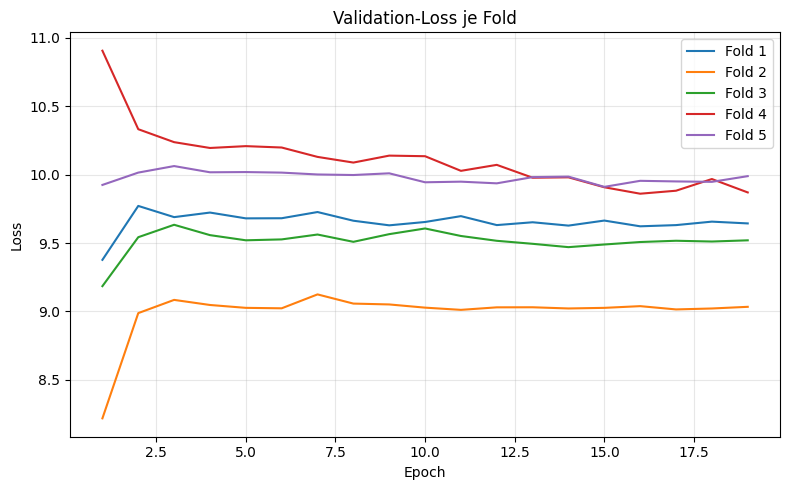

[I 2025-05-28 01:14:09,046] Trial 7 finished with value: 9.611313991603513 and parameters: {'hidden1': 384, 'hidden2': 192, 'hidden3': 192, 'drop1': 0.31877873567760656, 'drop2': 0.44360637128816327, 'drop3': 0.23610746258097465, 'lr': 1.7345566642360933e-05, 'weight_decay': 0.0007128188058401369, 'batch_size': 64, 'num_epochs': 19}. Best is trial 2 with value: 0.35795241597956234.



⟹ Ø Validation-Loss über 5 Folds: 9.6113

─── Fold 1 ───
Fold 1 | Epoch  1/25 | val loss: 10.3472
Fold 1 | Epoch  2/25 | val loss: 10.1372
Fold 1 | Epoch  3/25 | val loss: 9.8633
Fold 1 | Epoch  4/25 | val loss: 9.7340
Fold 1 | Epoch  5/25 | val loss: 9.6329
Fold 1 | Epoch  6/25 | val loss: 9.2380
Fold 1 | Epoch  7/25 | val loss: 9.3258
Fold 1 | Epoch  8/25 | val loss: 8.7790
Fold 1 | Epoch  9/25 | val loss: 8.8185
Fold 1 | Epoch 10/25 | val loss: 8.6183
Fold 1 | Epoch 11/25 | val loss: 8.2819
Fold 1 | Epoch 12/25 | val loss: 7.7834
Fold 1 | Epoch 13/25 | val loss: 7.4231
Fold 1 | Epoch 14/25 | val loss: 6.7636
Fold 1 | Epoch 15/25 | val loss: 6.5964
Fold 1 | Epoch 16/25 | val loss: 6.0351
Fold 1 | Epoch 17/25 | val loss: 5.5797
Fold 1 | Epoch 18/25 | val loss: 5.2512
Fold 1 | Epoch 19/25 | val loss: 4.6097
Fold 1 | Epoch 20/25 | val loss: 4.1682
Fold 1 | Epoch 21/25 | val loss: 3.8730
Fold 1 | Epoch 22/25 | val loss: 3.3691
Fold 1 | Epoch 23/25 | val loss: 2.9250
Fold 1 | Epoch 24/25

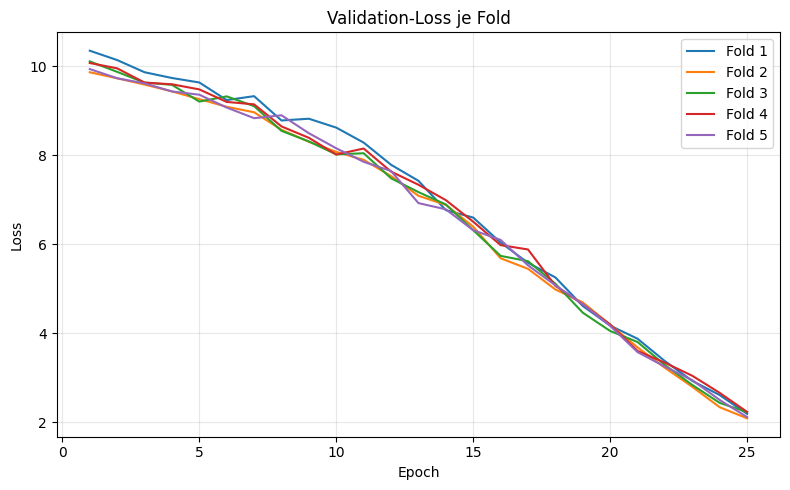

[I 2025-05-28 01:15:26,208] Trial 8 finished with value: 2.1666910519228155 and parameters: {'hidden1': 512, 'hidden2': 256, 'hidden3': 64, 'drop1': 0.053945713496652226, 'drop2': 0.015714592843367126, 'drop3': 0.3182052056318902, 'lr': 4.253162363790868e-05, 'weight_decay': 0.00010821382910613992, 'batch_size': 16, 'num_epochs': 25}. Best is trial 2 with value: 0.35795241597956234.



⟹ Ø Validation-Loss über 5 Folds: 2.1667

─── Fold 1 ───
Fold 1 | Epoch  1/20 | val loss: 10.6630
Fold 1 | Epoch  2/20 | val loss: 10.2525
Fold 1 | Epoch  3/20 | val loss: 9.8924
Fold 1 | Epoch  4/20 | val loss: 9.8056
Fold 1 | Epoch  5/20 | val loss: 9.4817
Fold 1 | Epoch  6/20 | val loss: 9.1964
Fold 1 | Epoch  7/20 | val loss: 8.9622
Fold 1 | Epoch  8/20 | val loss: 8.5799
Fold 1 | Epoch  9/20 | val loss: 8.1956
Fold 1 | Epoch 10/20 | val loss: 7.7293
Fold 1 | Epoch 11/20 | val loss: 7.1775
Fold 1 | Epoch 12/20 | val loss: 6.6892
Fold 1 | Epoch 13/20 | val loss: 6.0943
Fold 1 | Epoch 14/20 | val loss: 5.3653
Fold 1 | Epoch 15/20 | val loss: 4.7505
Fold 1 | Epoch 16/20 | val loss: 4.2455
Fold 1 | Epoch 17/20 | val loss: 3.6450
Fold 1 | Epoch 18/20 | val loss: 3.1005
Fold 1 | Epoch 19/20 | val loss: 2.6687
Fold 1 | Epoch 20/20 | val loss: 2.2219

─── Fold 2 ───
Fold 2 | Epoch  1/20 | val loss: 10.4281
Fold 2 | Epoch  2/20 | val loss: 10.0353
Fold 2 | Epoch  3/20 | val loss: 9.7920
Fo

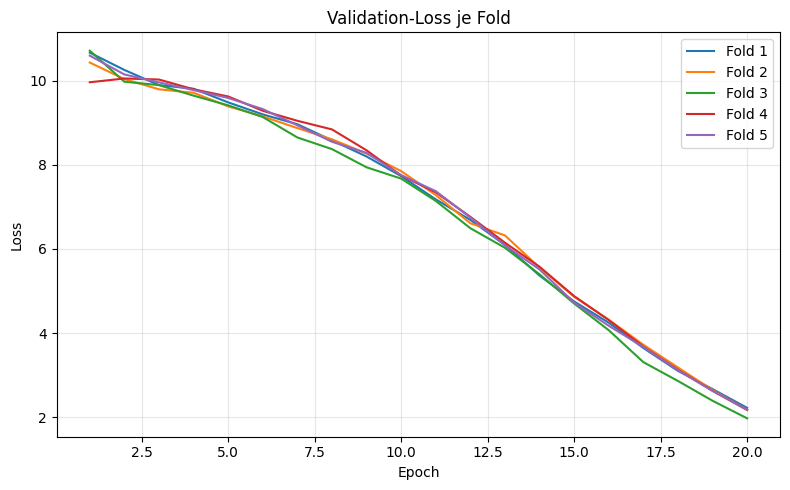

[I 2025-05-28 01:16:00,339] Trial 9 finished with value: 2.1437936144563574 and parameters: {'hidden1': 384, 'hidden2': 128, 'hidden3': 64, 'drop1': 0.08061064362700221, 'drop2': 0.46484882617128653, 'drop3': 0.4040601897822085, 'lr': 0.00018484491720988634, 'weight_decay': 0.0030608522106722507, 'batch_size': 64, 'num_epochs': 20}. Best is trial 2 with value: 0.35795241597956234.



⟹ Ø Validation-Loss über 5 Folds: 2.1438

─── Fold 1 ───
Fold 1 | Epoch  1/30 | val loss: 8.8433
Fold 1 | Epoch  2/30 | val loss: 2.6985
Fold 1 | Epoch  3/30 | val loss: 0.6801
Fold 1 | Epoch  4/30 | val loss: 0.4149
Fold 1 | Epoch  5/30 | val loss: 0.3780
Fold 1 | Epoch  6/30 | val loss: 0.3870
Fold 1 | Epoch  7/30 | val loss: 0.3303
Fold 1 | Epoch  8/30 | val loss: 0.3280
Fold 1 | Epoch  9/30 | val loss: 0.3986
Fold 1 | Epoch 10/30 | val loss: 0.3677
Fold 1 | Epoch 11/30 | val loss: 0.3736
Fold 1 | Epoch 12/30 | val loss: 0.3281
Fold 1 | Epoch 13/30 | val loss: 0.3276
Fold 1 | Epoch 14/30 | val loss: 0.3292
Fold 1 | Epoch 15/30 | val loss: 0.3329
Fold 1 | Epoch 16/30 | val loss: 0.3349
Fold 1 | Epoch 17/30 | val loss: 0.3166
Fold 1 | Epoch 18/30 | val loss: 0.3189
Fold 1 | Epoch 19/30 | val loss: 0.3381
Fold 1 | Epoch 20/30 | val loss: 0.3250
Fold 1 | Epoch 21/30 | val loss: 0.3191
Fold 1 | Epoch 22/30 | val loss: 0.3157
Fold 1 | Epoch 23/30 | val loss: 0.3190
Fold 1 | Epoch 24/30 |

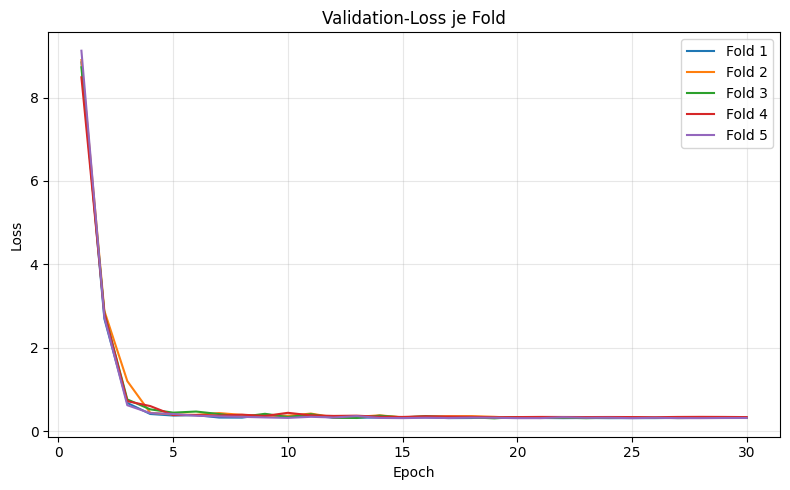

[I 2025-05-28 01:16:49,813] Trial 10 finished with value: 0.32595037646561464 and parameters: {'hidden1': 704, 'hidden2': 640, 'hidden3': 640, 'drop1': 0.4661451709558936, 'drop2': 0.30833844698414775, 'drop3': 0.1439331386146006, 'lr': 0.0007661823837602414, 'weight_decay': 1.1153479732703484e-06, 'batch_size': 64, 'num_epochs': 30}. Best is trial 10 with value: 0.32595037646561464.



⟹ Ø Validation-Loss über 5 Folds: 0.3260

─── Fold 1 ───
Fold 1 | Epoch  1/30 | val loss: 8.7054
Fold 1 | Epoch  2/30 | val loss: 1.8396
Fold 1 | Epoch  3/30 | val loss: 0.5543
Fold 1 | Epoch  4/30 | val loss: 0.4359
Fold 1 | Epoch  5/30 | val loss: 0.3639
Fold 1 | Epoch  6/30 | val loss: 0.3996
Fold 1 | Epoch  7/30 | val loss: 0.3333
Fold 1 | Epoch  8/30 | val loss: 0.3453
Fold 1 | Epoch  9/30 | val loss: 0.3544
Fold 1 | Epoch 10/30 | val loss: 0.3325
Fold 1 | Epoch 11/30 | val loss: 0.3417
Fold 1 | Epoch 12/30 | val loss: 0.3289
Fold 1 | Epoch 13/30 | val loss: 0.3259
Fold 1 | Epoch 14/30 | val loss: 0.3611
Fold 1 | Epoch 15/30 | val loss: 0.3341
Fold 1 | Epoch 16/30 | val loss: 0.3739
Fold 1 | Epoch 17/30 | val loss: 0.3242
Fold 1 | Epoch 18/30 | val loss: 0.3202
Fold 1 | Epoch 19/30 | val loss: 0.3290
Fold 1 | Epoch 20/30 | val loss: 0.3258
Fold 1 | Epoch 21/30 | val loss: 0.3204
Fold 1 | Epoch 22/30 | val loss: 0.3179
Fold 1 | Epoch 23/30 | val loss: 0.3180
Fold 1 | Epoch 24/30 |

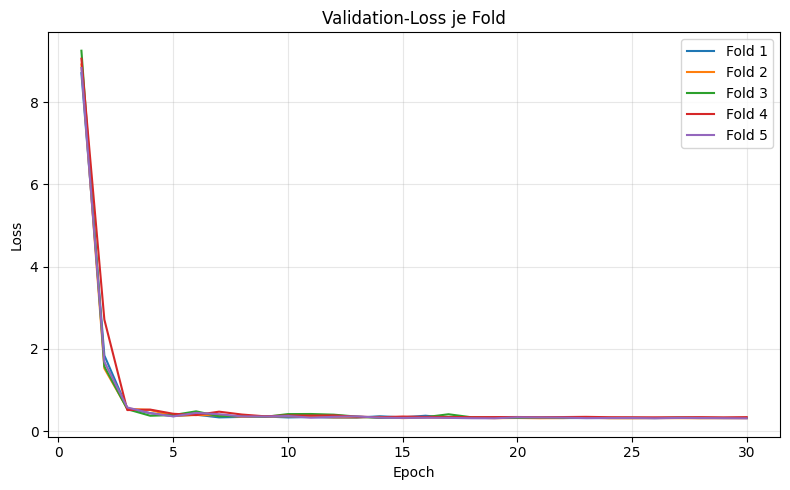

[I 2025-05-28 01:17:32,802] Trial 11 finished with value: 0.32055300938259873 and parameters: {'hidden1': 704, 'hidden2': 704, 'hidden3': 704, 'drop1': 0.4896409741615937, 'drop2': 0.29912598226066306, 'drop3': 0.122462754472871, 'lr': 0.000848722335545306, 'weight_decay': 1.0400252139081835e-06, 'batch_size': 64, 'num_epochs': 30}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3206

─── Fold 1 ───
Fold 1 | Epoch  1/30 | val loss: 8.7051
Fold 1 | Epoch  2/30 | val loss: 0.9471
Fold 1 | Epoch  3/30 | val loss: 0.4528
Fold 1 | Epoch  4/30 | val loss: 0.4378
Fold 1 | Epoch  5/30 | val loss: 0.4660
Fold 1 | Epoch  6/30 | val loss: 0.3760
Fold 1 | Epoch  7/30 | val loss: 0.3700
Fold 1 | Epoch  8/30 | val loss: 0.5319
Fold 1 | Epoch  9/30 | val loss: 0.3680
Fold 1 | Epoch 10/30 | val loss: 0.3190
Fold 1 | Epoch 11/30 | val loss: 0.3224
Fold 1 | Epoch 12/30 | val loss: 0.3353
Fold 1 | Epoch 13/30 | val loss: 0.3455
Fold 1 | Epoch 14/30 | val loss: 0.3710
Fold 1 | Epoch 15/30 | val loss: 0.3129
Fold 1 | Epoch 16/30 | val loss: 0.3100
Fold 1 | Epoch 17/30 | val loss: 0.3325
Fold 1 | Epoch 18/30 | val loss: 0.3823
Fold 1 | Epoch 19/30 | val loss: 0.3526
Fold 1 | Epoch 20/30 | val loss: 0.3163
Fold 1 | Epoch 21/30 | val loss: 0.3222
Fold 1 | Epoch 22/30 | val loss: 0.3230
Fold 1 | Epoch 23/30 | val loss: 0.3202
Fold 1 | Epoch 24/30 |

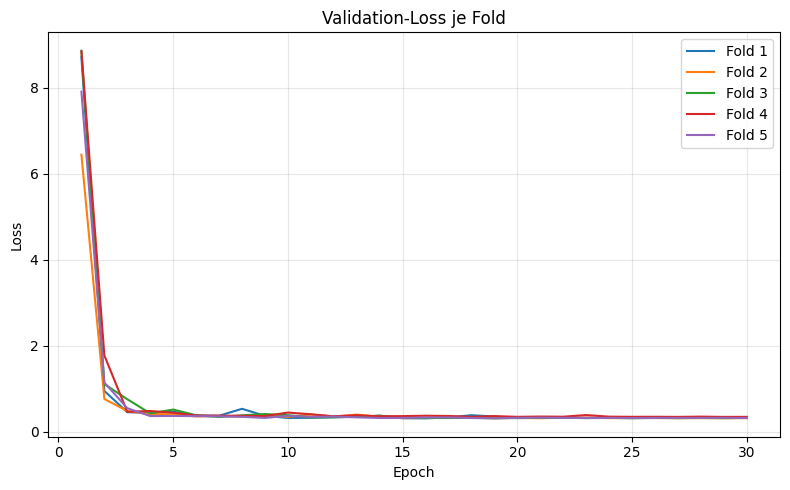

[I 2025-05-28 01:18:12,696] Trial 12 finished with value: 0.3233127256818359 and parameters: {'hidden1': 768, 'hidden2': 768, 'hidden3': 768, 'drop1': 0.47780898541722444, 'drop2': 0.26981005340139885, 'drop3': 0.13511619093204535, 'lr': 0.0009639412453600864, 'weight_decay': 1.0938041984857776e-06, 'batch_size': 64, 'num_epochs': 30}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3233

─── Fold 1 ───
Fold 1 | Epoch  1/25 | val loss: 9.5768
Fold 1 | Epoch  2/25 | val loss: 1.5454
Fold 1 | Epoch  3/25 | val loss: 0.5117
Fold 1 | Epoch  4/25 | val loss: 0.3844
Fold 1 | Epoch  5/25 | val loss: 0.3777
Fold 1 | Epoch  6/25 | val loss: 0.4529
Fold 1 | Epoch  7/25 | val loss: 0.3351
Fold 1 | Epoch  8/25 | val loss: 0.3379
Fold 1 | Epoch  9/25 | val loss: 0.3387
Fold 1 | Epoch 10/25 | val loss: 0.3357
Fold 1 | Epoch 11/25 | val loss: 0.3303
Fold 1 | Epoch 12/25 | val loss: 0.3285
Fold 1 | Epoch 13/25 | val loss: 0.3446
Fold 1 | Epoch 14/25 | val loss: 0.3385
Fold 1 | Epoch 15/25 | val loss: 0.3133
Fold 1 | Epoch 16/25 | val loss: 0.3447
Fold 1 | Epoch 17/25 | val loss: 0.3225
Fold 1 | Epoch 18/25 | val loss: 0.3248
Fold 1 | Epoch 19/25 | val loss: 0.3259
Fold 1 | Epoch 20/25 | val loss: 0.3200
Fold 1 | Epoch 21/25 | val loss: 0.3330
Fold 1 | Epoch 22/25 | val loss: 0.3162
Fold 1 | Epoch 23/25 | val loss: 0.3245
Fold 1 | Epoch 24/25 |

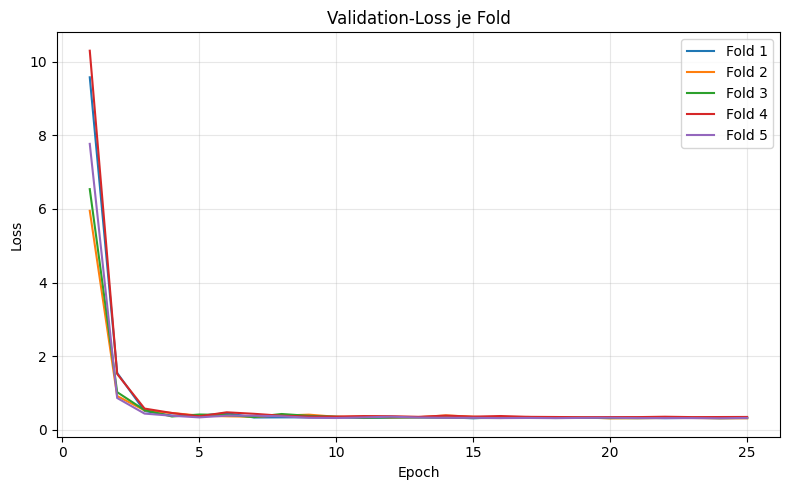

[I 2025-05-28 01:18:43,548] Trial 13 finished with value: 0.3256048446661662 and parameters: {'hidden1': 768, 'hidden2': 768, 'hidden3': 768, 'drop1': 0.4990182314147502, 'drop2': 0.23141893883111672, 'drop3': 0.14048592546261446, 'lr': 0.0009419378671446957, 'weight_decay': 1.664631900722604e-05, 'batch_size': 64, 'num_epochs': 25}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3256

─── Fold 1 ───
Fold 1 | Epoch  1/27 | val loss: 9.8911
Fold 1 | Epoch  2/27 | val loss: 7.8898
Fold 1 | Epoch  3/27 | val loss: 4.4590
Fold 1 | Epoch  4/27 | val loss: 1.7143
Fold 1 | Epoch  5/27 | val loss: 0.6326
Fold 1 | Epoch  6/27 | val loss: 0.4834
Fold 1 | Epoch  7/27 | val loss: 0.4319
Fold 1 | Epoch  8/27 | val loss: 0.3836
Fold 1 | Epoch  9/27 | val loss: 0.3938
Fold 1 | Epoch 10/27 | val loss: 0.3776
Fold 1 | Epoch 11/27 | val loss: 0.3387
Fold 1 | Epoch 12/27 | val loss: 0.3715
Fold 1 | Epoch 13/27 | val loss: 0.3355
Fold 1 | Epoch 14/27 | val loss: 0.3511
Fold 1 | Epoch 15/27 | val loss: 0.3556
Fold 1 | Epoch 16/27 | val loss: 0.3687
Fold 1 | Epoch 17/27 | val loss: 0.3387
Fold 1 | Epoch 18/27 | val loss: 0.3306
Fold 1 | Epoch 19/27 | val loss: 0.3342
Fold 1 | Epoch 20/27 | val loss: 0.3334
Fold 1 | Epoch 21/27 | val loss: 0.3346
Fold 1 | Epoch 22/27 | val loss: 0.3280
Fold 1 | Epoch 23/27 | val loss: 0.3294
Fold 1 | Epoch 24/27 |

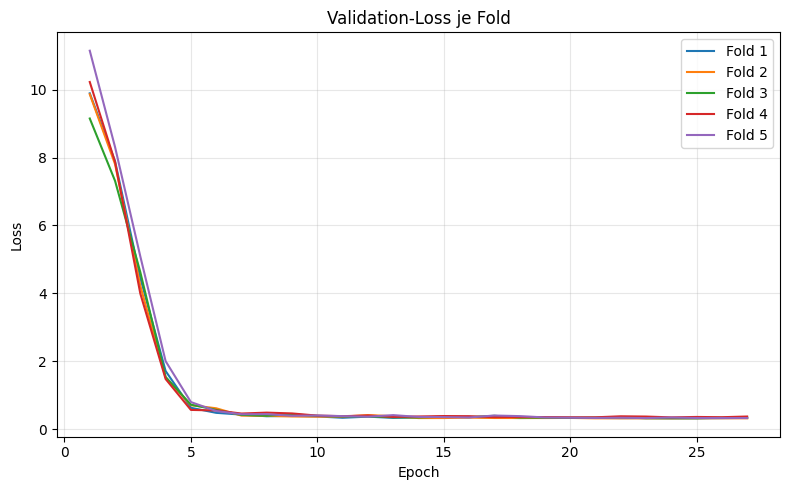

[I 2025-05-28 01:19:17,715] Trial 14 finished with value: 0.34113354634331866 and parameters: {'hidden1': 640, 'hidden2': 640, 'hidden3': 576, 'drop1': 0.42691086123279537, 'drop2': 0.23044535705503508, 'drop3': 0.13756151860158478, 'lr': 0.00039728269020550434, 'weight_decay': 1.0162358646920928e-06, 'batch_size': 64, 'num_epochs': 27}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3411

─── Fold 1 ───
Fold 1 | Epoch  1/23 | val loss: 10.8392
Fold 1 | Epoch  2/23 | val loss: 6.6424
Fold 1 | Epoch  3/23 | val loss: 1.7035
Fold 1 | Epoch  4/23 | val loss: 0.8700
Fold 1 | Epoch  5/23 | val loss: 0.4306
Fold 1 | Epoch  6/23 | val loss: 0.5079
Fold 1 | Epoch  7/23 | val loss: 0.3655
Fold 1 | Epoch  8/23 | val loss: 0.3770
Fold 1 | Epoch  9/23 | val loss: 0.3621
Fold 1 | Epoch 10/23 | val loss: 0.3583
Fold 1 | Epoch 11/23 | val loss: 0.3470
Fold 1 | Epoch 12/23 | val loss: 0.3521
Fold 1 | Epoch 13/23 | val loss: 0.3437
Fold 1 | Epoch 14/23 | val loss: 0.3685
Fold 1 | Epoch 15/23 | val loss: 0.3576
Fold 1 | Epoch 16/23 | val loss: 0.3486
Fold 1 | Epoch 17/23 | val loss: 0.3362
Fold 1 | Epoch 18/23 | val loss: 0.3242
Fold 1 | Epoch 19/23 | val loss: 0.3166
Fold 1 | Epoch 20/23 | val loss: 0.3316
Fold 1 | Epoch 21/23 | val loss: 0.3186
Fold 1 | Epoch 22/23 | val loss: 0.3360
Fold 1 | Epoch 23/23 | val loss: 0.3258

─── Fold 2 ───
Fold 

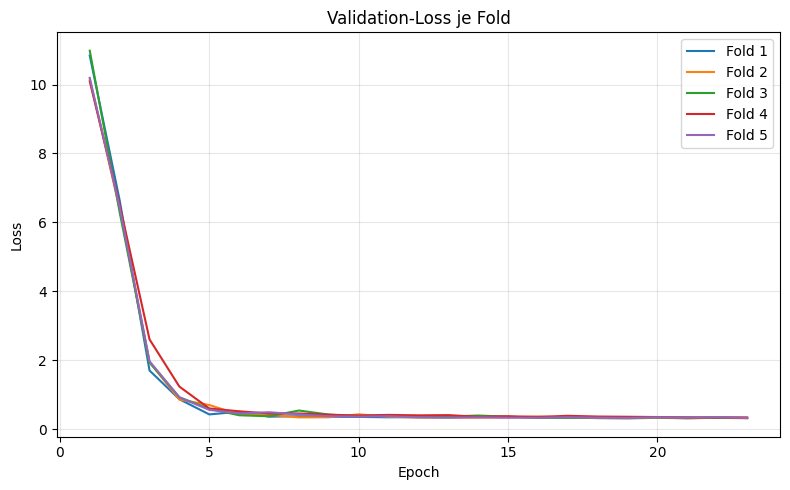

[I 2025-05-28 01:19:47,232] Trial 15 finished with value: 0.3283143550527943 and parameters: {'hidden1': 768, 'hidden2': 768, 'hidden3': 768, 'drop1': 0.4385619636874988, 'drop2': 0.3535301516659178, 'drop3': 0.1778536164868808, 'lr': 0.00047761563912655043, 'weight_decay': 6.177562735490056e-05, 'batch_size': 64, 'num_epochs': 23}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3283

─── Fold 1 ───
Fold 1 | Epoch  1/28 | val loss: 10.7446
Fold 1 | Epoch  2/28 | val loss: 7.6599
Fold 1 | Epoch  3/28 | val loss: 4.0207
Fold 1 | Epoch  4/28 | val loss: 1.1374
Fold 1 | Epoch  5/28 | val loss: 0.7975
Fold 1 | Epoch  6/28 | val loss: 0.4691
Fold 1 | Epoch  7/28 | val loss: 0.3861
Fold 1 | Epoch  8/28 | val loss: 0.3844
Fold 1 | Epoch  9/28 | val loss: 0.3618
Fold 1 | Epoch 10/28 | val loss: 0.3688
Fold 1 | Epoch 11/28 | val loss: 0.3683
Fold 1 | Epoch 12/28 | val loss: 0.3884
Fold 1 | Epoch 13/28 | val loss: 0.3440
Fold 1 | Epoch 14/28 | val loss: 0.3559
Fold 1 | Epoch 15/28 | val loss: 0.3424
Fold 1 | Epoch 16/28 | val loss: 0.3387
Fold 1 | Epoch 17/28 | val loss: 0.3312
Fold 1 | Epoch 18/28 | val loss: 0.3426
Fold 1 | Epoch 19/28 | val loss: 0.3362
Fold 1 | Epoch 20/28 | val loss: 0.3483
Fold 1 | Epoch 21/28 | val loss: 0.3416
Fold 1 | Epoch 22/28 | val loss: 0.3276
Fold 1 | Epoch 23/28 | val loss: 0.3380
Fold 1 | Epoch 24/28 

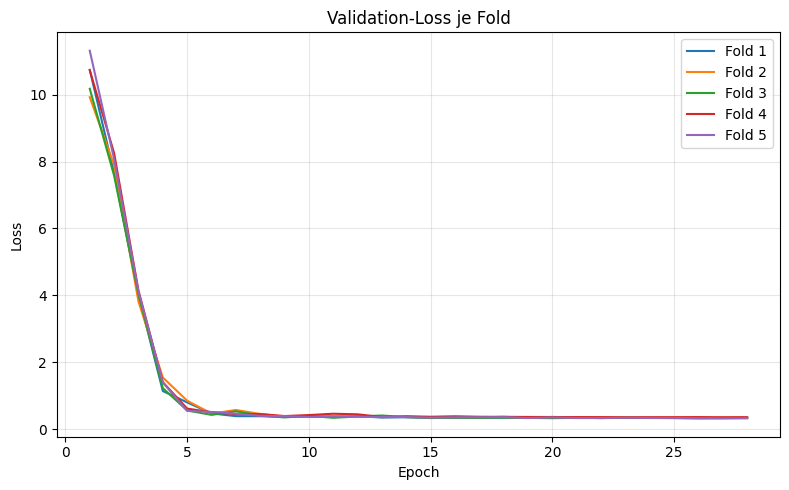

[I 2025-05-28 01:20:30,749] Trial 16 finished with value: 0.3370151629108298 and parameters: {'hidden1': 640, 'hidden2': 576, 'hidden3': 512, 'drop1': 0.38115582521450936, 'drop2': 0.1668704927750811, 'drop3': 0.08694206204366536, 'lr': 0.00040429622541605714, 'weight_decay': 5.410146690006127e-06, 'batch_size': 64, 'num_epochs': 28}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3370

─── Fold 1 ───
Fold 1 | Epoch  1/30 | val loss: 10.1059
Fold 1 | Epoch  2/30 | val loss: 6.2330
Fold 1 | Epoch  3/30 | val loss: 2.2493
Fold 1 | Epoch  4/30 | val loss: 0.9512
Fold 1 | Epoch  5/30 | val loss: 0.4313
Fold 1 | Epoch  6/30 | val loss: 0.3655
Fold 1 | Epoch  7/30 | val loss: 0.3521
Fold 1 | Epoch  8/30 | val loss: 0.4398
Fold 1 | Epoch  9/30 | val loss: 0.3647
Fold 1 | Epoch 10/30 | val loss: 0.3621
Fold 1 | Epoch 11/30 | val loss: 0.3338
Fold 1 | Epoch 12/30 | val loss: 0.3300
Fold 1 | Epoch 13/30 | val loss: 0.3511
Fold 1 | Epoch 14/30 | val loss: 0.3391
Fold 1 | Epoch 15/30 | val loss: 0.3518
Fold 1 | Epoch 16/30 | val loss: 0.3201
Fold 1 | Epoch 17/30 | val loss: 0.3202
Fold 1 | Epoch 18/30 | val loss: 0.3243
Fold 1 | Epoch 19/30 | val loss: 0.3154
Fold 1 | Epoch 20/30 | val loss: 0.3226
Fold 1 | Epoch 21/30 | val loss: 0.3218
Fold 1 | Epoch 22/30 | val loss: 0.3261
Fold 1 | Epoch 23/30 | val loss: 0.3179
Fold 1 | Epoch 24/30 

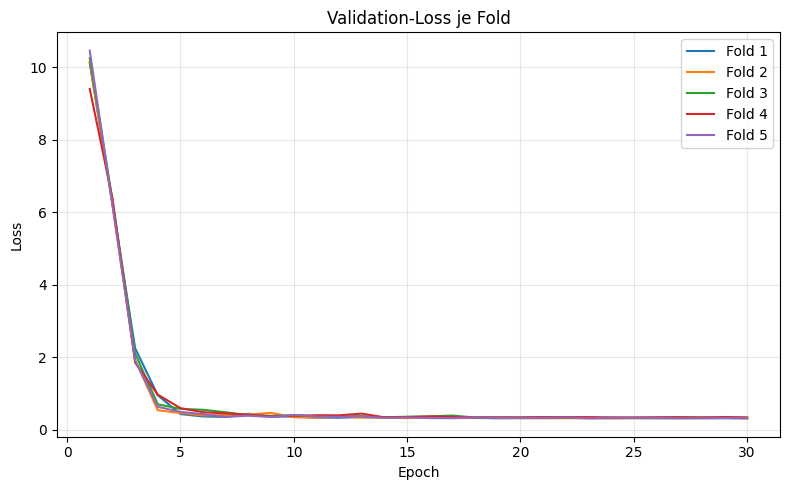

[I 2025-05-28 01:21:15,798] Trial 17 finished with value: 0.3238039117869378 and parameters: {'hidden1': 640, 'hidden2': 576, 'hidden3': 384, 'drop1': 0.4826162589395973, 'drop2': 0.2825269757813547, 'drop3': 0.18356405236979448, 'lr': 0.0006134472515577442, 'weight_decay': 0.00014422152510234213, 'batch_size': 64, 'num_epochs': 30}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3238

─── Fold 1 ───
Fold 1 | Epoch  1/22 | val loss: 10.4498
Fold 1 | Epoch  2/22 | val loss: 9.1563
Fold 1 | Epoch  3/22 | val loss: 7.7343
Fold 1 | Epoch  4/22 | val loss: 5.7598
Fold 1 | Epoch  5/22 | val loss: 3.3224
Fold 1 | Epoch  6/22 | val loss: 1.8649
Fold 1 | Epoch  7/22 | val loss: 0.9212
Fold 1 | Epoch  8/22 | val loss: 0.5676
Fold 1 | Epoch  9/22 | val loss: 0.5210
Fold 1 | Epoch 10/22 | val loss: 0.4718
Fold 1 | Epoch 11/22 | val loss: 0.4445
Fold 1 | Epoch 12/22 | val loss: 0.4333
Fold 1 | Epoch 13/22 | val loss: 0.3704
Fold 1 | Epoch 14/22 | val loss: 0.3822
Fold 1 | Epoch 15/22 | val loss: 0.3906
Fold 1 | Epoch 16/22 | val loss: 0.3747
Fold 1 | Epoch 17/22 | val loss: 0.3462
Fold 1 | Epoch 18/22 | val loss: 0.3369
Fold 1 | Epoch 19/22 | val loss: 0.3484
Fold 1 | Epoch 20/22 | val loss: 0.3361
Fold 1 | Epoch 21/22 | val loss: 0.3414
Fold 1 | Epoch 22/22 | val loss: 0.3454

─── Fold 2 ───
Fold 2 | Epoch  1/22 | val loss: 8.9069
Fold 

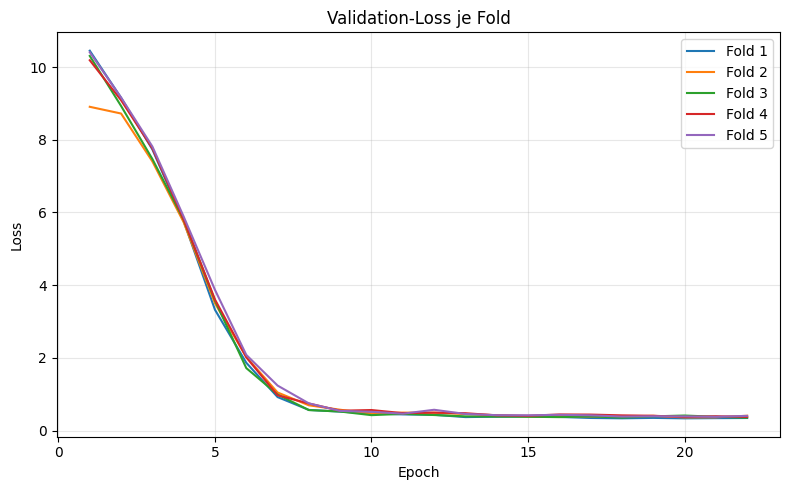

[I 2025-05-28 01:21:45,160] Trial 18 finished with value: 0.37701908848220633 and parameters: {'hidden1': 704, 'hidden2': 640, 'hidden3': 576, 'drop1': 0.33667335232721735, 'drop2': 0.38036091559184676, 'drop3': 0.33253548432611524, 'lr': 0.0002910497408036182, 'weight_decay': 3.40549611693018e-05, 'batch_size': 64, 'num_epochs': 22}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3770

─── Fold 1 ───
Fold 1 | Epoch  1/22 | val loss: 6.6923
Fold 1 | Epoch  2/22 | val loss: 1.4934
Fold 1 | Epoch  3/22 | val loss: 0.6916
Fold 1 | Epoch  4/22 | val loss: 0.4602
Fold 1 | Epoch  5/22 | val loss: 0.3948
Fold 1 | Epoch  6/22 | val loss: 0.3809
Fold 1 | Epoch  7/22 | val loss: 0.3588
Fold 1 | Epoch  8/22 | val loss: 0.3567
Fold 1 | Epoch  9/22 | val loss: 0.3746
Fold 1 | Epoch 10/22 | val loss: 0.3444
Fold 1 | Epoch 11/22 | val loss: 0.3605
Fold 1 | Epoch 12/22 | val loss: 0.3509
Fold 1 | Epoch 13/22 | val loss: 0.3611
Fold 1 | Epoch 14/22 | val loss: 0.3207
Fold 1 | Epoch 15/22 | val loss: 0.3212
Fold 1 | Epoch 16/22 | val loss: 0.3241
Fold 1 | Epoch 17/22 | val loss: 0.3271
Fold 1 | Epoch 18/22 | val loss: 0.3382
Fold 1 | Epoch 19/22 | val loss: 0.3236
Fold 1 | Epoch 20/22 | val loss: 0.3361
Fold 1 | Epoch 21/22 | val loss: 0.3255
Fold 1 | Epoch 22/22 | val loss: 0.3241

─── Fold 2 ───
Fold 2 | Epoch  1/22 | val loss: 6.7976
Fold 2

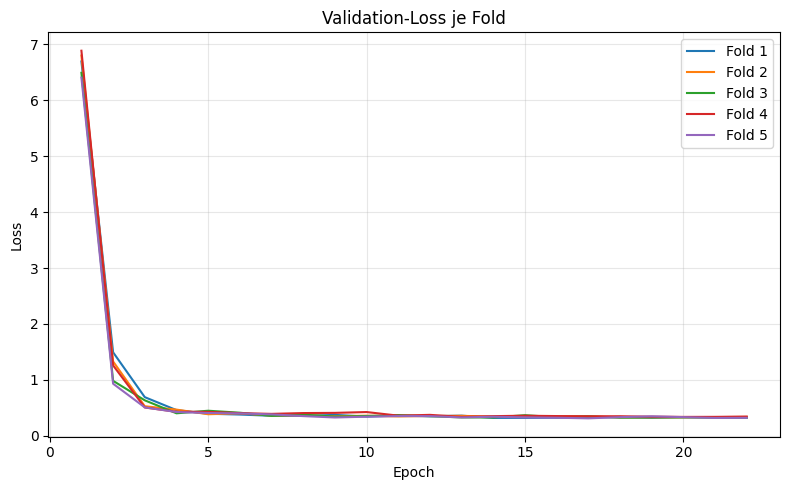

[I 2025-05-28 01:22:53,779] Trial 19 finished with value: 0.33103822361237367 and parameters: {'hidden1': 768, 'hidden2': 768, 'hidden3': 704, 'drop1': 0.42043512198434263, 'drop2': 0.20208437711808125, 'drop3': 0.08702598350031499, 'lr': 0.00024899652149944516, 'weight_decay': 0.00042556535544764423, 'batch_size': 16, 'num_epochs': 22}. Best is trial 11 with value: 0.32055300938259873.



⟹ Ø Validation-Loss über 5 Folds: 0.3310
Beste Parameter: {'hidden1': 704, 'hidden2': 704, 'hidden3': 704, 'drop1': 0.4896409741615937, 'drop2': 0.29912598226066306, 'drop3': 0.122462754472871, 'lr': 0.000848722335545306, 'weight_decay': 1.0400252139081835e-06, 'batch_size': 64, 'num_epochs': 30}
Bester CV-Loss : 0.32055300938259873


In [16]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5),
)

study.optimize(objective, n_trials=20, timeout=None)   # passe n_trials nach Rechenbudget an
print("Beste Parameter:", study.best_params)
print("Bester CV-Loss :", study.best_value)



─── Fold 1 ───
Fold 1 | Epoch  1/30 | val loss: 10.1717
Fold 1 | Epoch  2/30 | val loss: 0.8933
Fold 1 | Epoch  3/30 | val loss: 0.5759
Fold 1 | Epoch  4/30 | val loss: 0.3916
Fold 1 | Epoch  5/30 | val loss: 0.4150
Fold 1 | Epoch  6/30 | val loss: 0.3530
Fold 1 | Epoch  7/30 | val loss: 0.3505
Fold 1 | Epoch  8/30 | val loss: 0.3385
Fold 1 | Epoch  9/30 | val loss: 0.3639
Fold 1 | Epoch 10/30 | val loss: 0.3548
Fold 1 | Epoch 11/30 | val loss: 0.3551
Fold 1 | Epoch 12/30 | val loss: 0.3328
Fold 1 | Epoch 13/30 | val loss: 0.3237
Fold 1 | Epoch 14/30 | val loss: 0.3188
Fold 1 | Epoch 15/30 | val loss: 0.3250
Fold 1 | Epoch 16/30 | val loss: 0.3185
Fold 1 | Epoch 17/30 | val loss: 0.3426
Fold 1 | Epoch 18/30 | val loss: 0.3172
Fold 1 | Epoch 19/30 | val loss: 0.3230
Fold 1 | Epoch 20/30 | val loss: 0.3182
Fold 1 | Epoch 21/30 | val loss: 0.3257
Fold 1 | Epoch 22/30 | val loss: 0.3143
Fold 1 | Epoch 23/30 | val loss: 0.3197
Fold 1 | Epoch 24/30 | val loss: 0.3188
Fold 1 | Epoch 25/30 | 

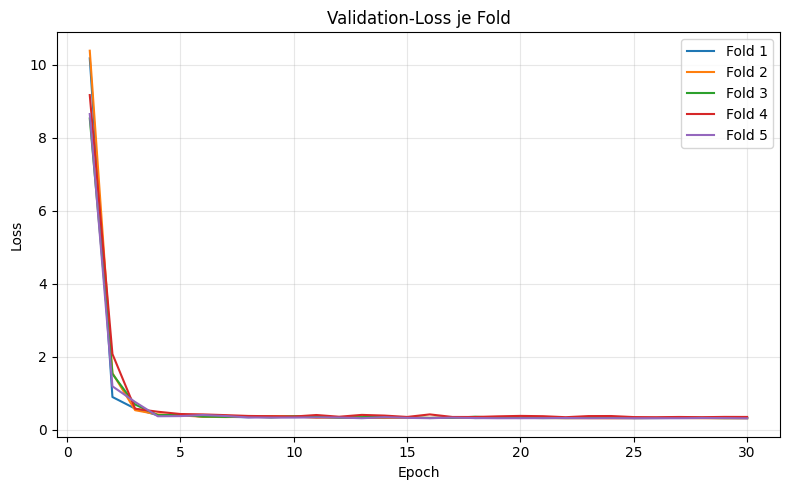


⟹ Ø Validation-Loss über 5 Folds: 0.3202


In [18]:
best = study.best_params
best_model_fn = lambda: make_model(
    best["hidden1"], best["hidden2"], best["hidden3"],
    best["drop1"],   best["drop2"],   best["drop3"],
)

# einmal auf *allen* Trainingsdaten trainieren
_, _, best_model = cross_validate_kfold(
    dataset,
    best_model_fn,
    k           = 5,               # kein CV mehr → ganzer Datensatz
    num_epochs  = best["num_epochs"],
    lr          = best["lr"],
    batch_size  = best["batch_size"],
    weight_decay= best["weight_decay"],
)
torch.save(best_model.state_dict(), "best_model.pt")


### Generate Submission

In [150]:
embeddings = sbert_model.encode(test["full_text"].tolist(), show_progress_bar=True)

# Optional: Embeddings in die DataFrame schreiben
test["embedding"] = embeddings.tolist()

Batches: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


In [151]:
class SBERTTestDataset(Dataset):
    def __init__(self, dataframe):
        self.ids = dataframe["text_id"].tolist()
        self.embeddings = dataframe["embedding"].tolist()

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        return self.ids[idx], embedding

In [152]:
test_dataset = SBERTTestDataset(test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [153]:
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

predictions = []
text_ids = []

with torch.no_grad():
    for ids, xb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        preds = preds.clamp(0, 5)
        preds = preds.cpu().numpy()
        predictions.extend(preds.tolist())
        text_ids.extend(ids)

submission_df = pd.DataFrame(predictions, columns=[
    "cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"
])
submission_df.insert(0, "text_id", text_ids)

submission_df.to_csv("submission.csv", index=False)